![](./img/upld_57150.jpeg)

# Дата-сайенc проект для компании Booking

In [2]:
# загружаем библиотеки
import pandas as pd
import numpy as np

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

# импортируем хи-квадрат
from sklearn.feature_selection import chi2 

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [18]:
# прописываем функции
def rev_func(num_tags):
    """Функция которая делит строку по разделителю

    Args:
        num_tags (object): строка, которую необходимо преобразовать в список

    Returns:
        list: список пригодный для дальнейшей обработки
    """
    # обрезаем ненужные символы по краям
    num_tags = num_tags[2:-2]
    # преобразуем в список который легче обработать
    res = num_tags.strip().split(' \', \' ')
    return res


def get_season(month):
    """Функция для определения времени года по номеру месяца

    Args:
        month (int): номер месяца в году от 1 до 12

    Returns:
        str: Название времени года: 4 варианта: winter, spring, summer, outumn
    """
    if month in [12,1,2]:
        season = 'winter'
    elif month in [3,4,5]:
        season = 'spring'
    elif month in [6,7,8]:
        season = 'summer'
    else:
        season = 'outumn'
    return season

In [4]:
# загружаем данные
hotels = pd.read_csv('data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [5]:
# знакомство с типами данных
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Вывод: нам есть что преобразовать

# Преобразование данных

In [6]:
# копируем исходный датасет для обработки данных
hotels_copy = hotels.copy()

In [7]:
# приводим признак  review_date к формату datetime
hotels_copy['review_date'] = pd.to_datetime(hotels_copy['review_date'], dayfirst=False)

In [8]:
# определяем период времени в который оставлены отзывы
hotels_copy['review_date'].sort_values(ascending=True)

143997   2015-08-04
86268    2015-08-04
159209   2015-08-04
217001   2015-08-04
28485    2015-08-04
            ...    
167325   2017-08-03
372341   2017-08-03
54669    2017-08-03
321881   2017-08-03
315137   2017-08-03
Name: review_date, Length: 386803, dtype: datetime64[ns]

1. Выделим из признака `review_date` категориальные признаки: `is_weekend_review` (1 - выходные, сб. вс., 0 - будни, пн.-пт.), `review_month` - месяц (1-12),  `review_season` - время года отзыва (1 - зима, 2 - весна, 3 - лето, 4 - осень)

In [43]:
hotels_copy['is_weekend_review'] = hotels_copy['review_date'].dt.dayofweek.apply(lambda x: 'weekend' if x in [5,6] else 'weekdays')
hotels_copy['is_weekend_review'].value_counts(normalize=True)*100

is_weekend_review
weekdays    73.640587
weekend     26.359413
Name: proportion, dtype: float64

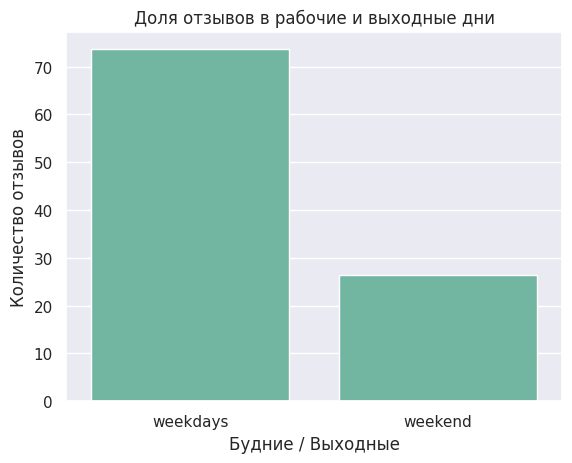

In [35]:
ax = sns.countplot(hotels_copy, x="is_weekend_review", stat='percent')
ax.set(xlabel='Будние / Выходные', ylabel='Количество отзывов')
plt.title('Доля отзывов в рабочие и выходные дни')
plt.show()

In [44]:
hotels_copy['review_weekday'] = hotels_copy['review_date'].dt.weekday
hotels_copy['review_weekday'].value_counts(normalize=True)*100

review_weekday
1    23.514295
6    16.296668
0    15.699465
3    14.441718
2    11.338071
5    10.062745
4     8.647037
Name: proportion, dtype: float64

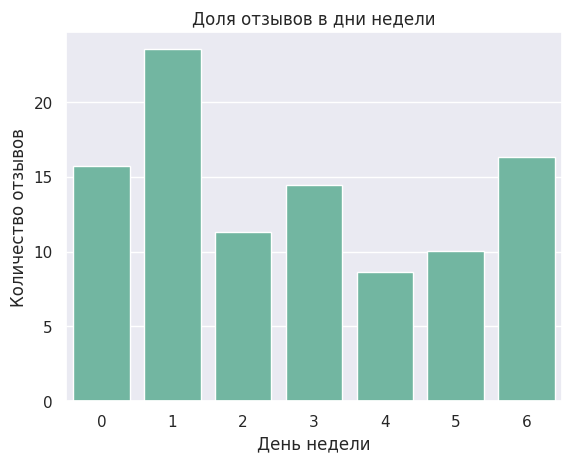

In [37]:
ax = sns.countplot(hotels_copy, x="review_weekday", stat='percent')
ax.set(xlabel='День недели', ylabel='Количество отзывов')
plt.title('Доля отзывов в дни недели')
plt.show()

In [17]:
hotels_copy['review_month'] = hotels_copy['review_date'].dt.month
(hotels_copy['review_month'].value_counts(normalize=True)*100).sort_index()

review_month
1     8.146783
2     7.428846
3     7.988821
4     8.328012
5     8.966838
6     8.331373
7     9.602045
8     9.801113
9     8.220722
10    8.524236
11    6.979522
12    7.681688
Name: proportion, dtype: float64

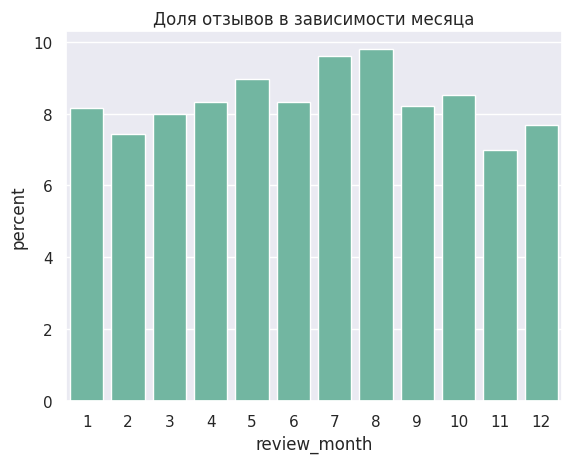

In [42]:
x = sns.countplot(hotels_copy, x="review_month", stat='percent')
ax.set(xlabel='Месяц', ylabel='Количество отзывов')
plt.title('Доля отзывов в зависимости месяца')
plt.show()

In [20]:
hotels_copy['review_season'] = hotels_copy['review_month'].apply(get_season)
(hotels_copy['review_season'].value_counts(normalize=True)*100)

review_season
summer    27.734532
spring    25.283672
outumn    23.724480
winter    23.257317
Name: proportion, dtype: float64

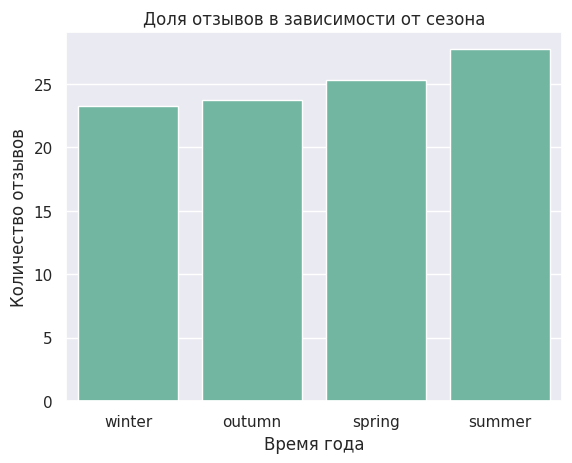

In [39]:
ax = sns.countplot(hotels_copy, x="review_season", stat='percent')
ax.set(xlabel='Время года', ylabel='Количество отзывов')
plt.title('Доля отзывов в зависимости от времени года')
plt.show()

**Выводы:** признак `is_weekend_review` делит данные неравномерно, но пропорционально среднедневному количеству отзывов, выглядит перспективно. Остальные признаки распределены +/- равномерно.

2. Выделим из признака `hotel_adress` страну расположения отеля и создадим признак `hotel_country`;

In [ ]:
hotels_copy['hotel_country'] = hotels_copy['hotel_adress']

In [37]:
n_hotels = hotels.copy()

def rev_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

n_hotels['tags_n'] = n_hotels['tags'].apply(rev_func)


n_hotels = n_hotels.explode('tags_n')
len(n_hotels['tags_n'].unique())

2368

In [39]:
n_hotels['tags_n'].value_counts()

tags_n
Leisure trip                         313593
Submitted from a mobile device       230778
Couple                               189212
Stayed 1 night                       145373
Stayed 2 nights                      100263
                                      ...  
Studio with Spa Access                    1
Comfort Family Room                       1
Junior Suite Free Wifi                    1
Design Suite                              1
Executive Double Room Non Smoking         1
Name: count, Length: 2368, dtype: int64

In [50]:
x = "[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']"
y = x[2:-2]
res = y.strip().split(' \', \' ')
print(res)

['Leisure trip', 'Couple', 'Studio Suite', 'Stayed 2 nights', 'Submitted from a mobile device']


In [36]:
to_list(hotels_copy['tags'])

["[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",
 "[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",
 "[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",
 "[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",
 "[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",
 "[' Business trip ', ' Solo traveler ', ' Superior Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",
 "[' Leisure trip ', ' Couple ', ' Double Room Non Smoking ', ' Stayed 1 night ', ' Submitted from a mobile device ']",
 "[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 4 nights ']",
 "[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ']",
 "[' Leisure trip ', ' Couple ', ' Twin Hilton Guest Room ', ' Stayed 1 night ', ' Submitted 

In [32]:
list(hotels_copy['tags'].values)[0]

"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']"

In [29]:
hotels_copy = hotels #.drop(columns=['hotel_address',
                                #    'review_date',
                                #    'hotel_name',
                                #    'reviewer_nationality',
                                #    'negative_review',
                                #    'positive_review',
                                #    'tags',
                                #    'days_since_review'])
   

In [30]:
values = {
    'lat': hotels_copy['lat'].mean(),
    'lng': hotels_copy['lng'].mean()
}
fill_data = hotels_copy.fillna(values)

In [31]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_copy.drop(['reviewer_score'], axis = 1)  
y = hotels_copy['reviewer_score'] 

In [32]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [33]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [25]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1412373255813556


Небольшой бонус:


In [24]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
hotels = hotels.fillna(0)

In [34]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', ...]

# категориальные признаки
cat_cols = ['average_score', 'lat', ...]

In [35]:
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

KeyError: '[Ellipsis] not in index'

In [13]:
df = pd.DataFrame({'A': [[0, 1, 2], 'foo', [], [3, 4]],
                   'B': [ 1, ['d', 'e'], ['a', 'b', 'c'], np.nan],
                   'C': [['a', 'b', 'c'], np.nan, [], ['d', 'e']]})
df


,A,B,C
0,"[0, 1, 2]",1,"[a, b, c]"
1,foo,"[d, e]",NaN
2,[],"[a, b, c]",[]
3,"[3, 4]",NaN,"[d, e]"


In [15]:
df.explode('A')

,A,B,C
0,0,1,"[a, b, c]"
0,1,1,"[a, b, c]"
0,2,1,"[a, b, c]"
1,foo,"[d, e]",NaN
2,NaN,"[a, b, c]",[]
3,3,NaN,"[d, e]"
3,4,NaN,"[d, e]"


In [19]:
s = pd.Series([[1, 2, 3], "foo", [], [1, 2, 3]])

display(s)

display(s.explode())

display(s.explode())


0    [1, 2, 3]
1          foo
2           []
3    [1, 2, 3]
dtype: object

0      1
0      2
0      3
1    foo
2    NaN
3      1
3      2
3      3
dtype: object

In [21]:
keys = ["panda1", "panda2", "panda3"]

values = [["eats", "eats", "shoots"], ["shoots", "leaves"], ["eats", "leaves"]]

df = pd.DataFrame({"keys": keys, "values": values})

display(df)


display(df["values"].explode())

,keys,values
0,panda1,"[eats, eats, shoots]"
1,panda2,"[shoots, leaves]"
2,panda3,"[eats, leaves]"


0      eats
0      eats
0    shoots
1    shoots
1    leaves
2      eats
2    leaves
Name: values, dtype: object